# SSM Driver
So what are we trying to do here? We're basically seeing if we can convince an ANN to predict the components of the SSM needed to match the measurements given as input. That way we can take 1D measurements and convert them into semi-realistic 3D data which would be nice. How we exactly are going to manage that? I honestly don't know. I guess the things we need are:
1. **Dataloader** - a means of generating pairs of 3D models, their components and their measurements. That means I actually need to nail down how we define these measurements in the first place which isnt entirely obvious. I guess I just go with something that looks reasonable for now and we can refine exactly where the measurements are taken at a later date. Either way we're going to be giving it 4 circumfrential measures, 2 widths and a length and we'll see what comes out of it. 
2. **Loss function** - How exactly are we defining this loss - probably easiest by just using MSE between the 2 sets of measurements but it might be worth normalising them against the reference measure so that everything is of the same magnitude. Also probably worth creating a class or something that can just be passed the verts and output a set of measurements - this probably should be a `nn.Module` shouldn't it so it gets those nice properties? Idk maybe that doesnt matter too much?
3. **Model** - This is probably the simplest part of the whole shabang. We can just start with a really simple dense network and see what happens. Maybe throw in some normalisation but really this should be as simple as possible.


Something I havent really thought too much about is that I need to create these limbs based on my components 

In [30]:
import torch
from torch import nn
import subprocess
import os
import numpy as np
import igl
import wandb
from tqdm import tqdm

from functools import partial
import measure_limbs

In [31]:
# selected_verts = []
# with open("verts.txt", "r") as f:
#     for line in f:
#         if line[0] == "#":
#             continue
#         else:
#             selected_verts.append([float(x) for x in line.strip().split(", ")])

# selected_verts = torch.tensor(selected_verts)

# verts, face2vert = igl.read_triangle_mesh("./meshes/limb_00000.stl")
# verts = torch.tensor(verts[torch.load("./data_components/vert_mapping.pt")])

# verts.shape, selected_verts.shape

# vert_idxs = torch.argmin(torch.linalg.norm(verts[None] - selected_verts[:, None], dim=-1), dim=-1)

# # with open("test_verts.obj", "w") as f:
# #     for v in vert_idxs:
# #         f.write(f"v {verts[v][0]} {verts[v][1]} {verts[v][2]}\n") 

# torch.save(vert_idxs, "data_components/selected_verts.pt")

In [32]:
config = {
    "lr": 1e-2,
    "eta_min": 0.00001,
    "batch_size": 256,
    "log": True,
    "seed": 42,
    "epochs":200,
}

torch.manual_seed(config["seed"])

if config["log"]:
    wandb.init(project="Open Limb SSM", config=config)

component loss,█▃▂▃▃▂▂▃▃▁▁▂▂▂▃▃▂▃▁▂▂▃▂▃▃▃▂▃▂▃▃▃▂▂▂▃▄▂▃▃
loss,█▄▄▄▃▂▂▂▂▂▁▁▁▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁
max_diff_Circumference 1,▆█▆█▅▄▄▃▄▅▅▃▂▃▃▃▄▅▄▁▅▂▂▄▃▅▃▂▇▄▄▄█▅▃▃▄▅▂▃
max_diff_Circumference 2,▇▇▅▆▂▇▅▂▅▅▃▆▂▂▃▆▄▇▃▃▁▂▅▂▃▅▃▃▅▃▅▂▂▆▃█▆▁▃▅
max_diff_Circumference 3,▆▆▅▅▃▄▅▄▂▂▄▄▂▄█▃▃▁▂▅▆▂▄▅▁▄▃▃▄▁▃▃▃▃▂▃▃▄▃▂
max_diff_Circumference 4,▄▃▄▆▄▅▂▆▆▄▃▄▂▂▆▃█▂▄▅▂▃▅▅▃▄▅▂▂▃▆▄▃▂▃▁▃▄▂▄
max_diff_Length 1,█▆▄▃▄▄▄▄▃▂▂▅▁▃▃▂▂▃▁▁▁▁▂▂▁▁▃▂▂▁▁▁▁▃▂▁▂▃▂▂
max_diff_Width 1,▆▄▆▂▃▂▂▄▂▂▃▁▄▃▇▃▄▂▂▅▂▄▂▂▂▁▅▅▂▁▄▁▂▄▃▁▂█▄▅
max_diff_Width 2,█▇▃▃▂▂▃▃▂▄▂▂▂▄▂▁▂▂▃▂▁▃▂▂▃▂▂▁▂▂▃▃▂▃▁▁▂▃▂▃
maximum measurement difference,▅█▅▄▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▃▂▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▂▂
maximum measurement difference raw,█▄▄▂▂▂▂▁▂▃▁▂▃▂▂▂▂▂▂▁▂▂▃▂▂▂▂▁▁▂▂▃▁▁▁▃▁▂▃▂


In [33]:
#| export
class Measurements(nn.Module):
    def __init__(self, edge2vert, face2edge, details, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.edge2vert = edge2vert
        self.face2edge = face2edge
        self.details = details
        self.measures = []

        for detail in details:
            match detail["type"]:
                case "width":
                    measure = partial(measure_limbs.measure_width,
                        edge2vert=self.edge2vert,
                        plane_point=detail["plane_point"],
                        plane_normal=detail["plane_normal"],
                        plane_direction=detail["plane_direction"],
                    )
                case "length":
                    measure = partial(measure_limbs.measure_length,
                        v1=detail["v1"], v2=detail["v2"], direction=detail["direction"]
                    )
                case "circumference":
                    measure = partial(measure_limbs.measure_planar_circumference,
                        edge2vert=self.edge2vert,
                        face2edge=self.face2edge,
                        plane_point=detail["plane_point"],
                        plane_normal=detail["plane_normal"],
                    )
            self.measures.append(measure)

    def forward(self, x, verbose=False):
        measures = [measure(x) for measure in self.measures]
        if verbose:
            for measure, detail in zip(measures, self.details):
                print(f"{detail['name'].ljust(20)}:\t\t{measure}")
        return torch.stack(measures, dim=-1)


In [34]:
#| export
class LegMeasurementDataset(torch.utils.data.Dataset):
    def __init__(self, measure, batch_size=64, path="./stls", dtype=torch.float64, device="cpu"):
        super().__init__()
        self.dtype = dtype
        self.device = device
        self.measure = measure
        self.batch_size = batch_size
        self.path = path
        self.loaded_components = {}
        self.raw_components = torch.load("./data_components/vert_components.pt").to(dtype).to(device)
        self.mean_verts = torch.load("./data_components/mean_verts.pt").to(dtype).to(device)
        self.face2vert = torch.load("./data_components/face2vert.pt").to(device)
        self.vert_mapping = torch.load("./data_components/vert_mapping.pt").to(device)
        self.component_transforms = torch.load("./data_components/scaled_component_transforms.pt").to(dtype).to(device)
        self.measurement_transforms = torch.load("./data_components/scaled_measurement_transforms.pt").to(dtype).to(device)

        # Remove all .npy files from the specified path
        for file in os.listdir(self.path):
            if file.endswith(".npy"):
                os.remove(os.path.join(self.path, file))

        self.generate_data(0)
        self.generate_data(self.batch_size)

    def __len__(self):
        return 100_000

    def __getitem__(self, index):
        if index % self.batch_size == 0:
            self.generate_data(index + self.batch_size*2)
            ith_dataset = index // self.batch_size
            if ith_dataset >= 2:
                self.delete_data((ith_dataset - 2)*self.batch_size)

        try:
            components = self.loaded_components[(index // self.batch_size)*self.batch_size][
                index % self.batch_size
            ]
        except KeyError:
            self.generate_data(index)
            components = self.loaded_components[(index // self.batch_size)*self.batch_size][
                index % self.batch_size
            ]

        verts = self.get_verts(components)

        measurements = self.get_measures(verts=verts, normalise=False).squeeze()

        return measurements, components
        # return verts, self.face2vert, measurements, components
    

    def get_verts(self, components):
        if len(components.shape) == 1:
            components, scale = components[:-1], components[-1:]
        else:
            components, scale = components[:,:-1], components[:,-1:]
        
        total = torch.sum(self.raw_components[None] * components[..., None], dim=1)
        verts = self.mean_verts[None] + total.reshape((total.shape[0], self.mean_verts.shape[0], self.mean_verts.shape[1]))
        verts = verts[:, self.vert_mapping]*scale[..., None]

        return verts.squeeze()
    
    def get_measures(self, components=None, verts=None, verbose=False, normalise=False):
        if components is not None:
            verts = self.get_verts(components)

        measurements = self.measure.forward(verts, verbose)

        if normalise:
            measurements = self.normalise_measures(measurements)

        return measurements
    
    def normalise_measures(self, measurements):
        return (measurements - self.measurement_transforms[:1]) / self.measurement_transforms[1:]

    def generate_data(self, start):
        cmd = [
            "./scripts/generate_limbs.sh",
            "--num_limbs",
            f"{self.batch_size}",
            "--path",
            self.path,
            "--start",
            f"{start}",
            "--save_mesh",
            "0",
            "--scale",
            "1",
            "--seed",
            f"{torch.randint(0, 100000, (1,))[0]}"
        ]
        if os.name == "nt":  # Windows
            cmd = ["wsl", "-e"] + cmd

        subprocess.run(cmd, check=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE)

        while True:
            try:
                components = np.load(f"{self.path}/components_{start:08d}.npy")
            except FileNotFoundError:
                continue
            else:
                self.loaded_components[start] = torch.tensor(components, dtype=self.dtype, device=self.device)
                break

    def delete_data(self, start):
        # for i in range(start, start + self.batch_size):
            # try:
            #     os.remove(f"{self.path}/limb_{i:05d}.npy")
            # except FileNotFoundError:
            #     pass

        os.remove(f"{self.path}/components_{start:08d}.npy")
        self.loaded_components.pop(start)

In [35]:
#| export_section
dtype = torch.float64

mean_verts = torch.load("./data_components/mean_verts.pt").to(dtype)
face2vert = torch.load("./data_components/face2vert.pt")

edge2vert, face2edge, edge2face = igl.edge_topology(
    mean_verts.numpy(), face2vert.numpy()
)

edge2vert = torch.from_numpy(edge2vert)
face2edge = torch.from_numpy(face2edge)
edge2face = torch.from_numpy(edge2face)

vert_idxs = torch.load("./data_components/selected_verts.pt")

# Order
# Mid patella tendon
# Distal tibia
# Knee widest
# Knee above? This one feels off
# Over fib head
# Fib head
# Circ 3
# Circ 4

measurement_details = (
    {
        # Circ one
        "type": "circumference",
        "plane_point": vert_idxs[4],
        "plane_normal": torch.tensor([[0, 0, 1]], dtype=dtype),
        "name":"Circumference 1",
    },
    {
        "type": "circumference",
        "plane_point": vert_idxs[5],
        "plane_normal": torch.tensor([[0, 0, 1]], dtype=dtype),
        "name":"Circumference 2",
    },
    {
        "type": "circumference",
        "plane_point": vert_idxs[6],
        "plane_normal": torch.tensor([[0, 0, 1]], dtype=dtype),
        "name":"Circumference 3",
    },
    {
        "type": "circumference",
        "plane_point": vert_idxs[7],
        "plane_normal": torch.tensor([[0, 0, 1]], dtype=dtype),
        "name":"Circumference 4",
    },
    {
        "type": "length", 
        "v1": vert_idxs[0], 
        "v2": vert_idxs[1], 
        "direction": torch.tensor([[0, 0, 1]], dtype=dtype),
        "name":"Length 1",
    },
    {
        "type": "width",
        "plane_point": vert_idxs[2],
        "plane_normal": torch.tensor([[0, 0, 1]], dtype=dtype),
        "plane_direction": torch.tensor([[1, 0, 0]], dtype=dtype),
        "name":"Width 1",
    },
    {
        "type": "width",
        "plane_point": vert_idxs[3],
        "plane_normal": torch.tensor([[0, 0, 1]], dtype=dtype),
        "plane_direction": torch.tensor([[1, 0, 0]], dtype=dtype),
        "name":"Width 2",
    },
)

measure = Measurements(
    edge2vert,
    face2edge,
    measurement_details,
)

#| end_section

In [36]:
class Model(nn.Module):
    def __init__(self, input_dims, output_dims, transforms, dtype, activation=nn.ReLU(inplace=True)):
        super().__init__()

        self.output_transform = transforms
        self.output_transform.requires_grad_(False)

        self.layers = nn.ParameterList([
            nn.Linear(input_dims, 256, dtype=dtype),
            nn.BatchNorm1d(num_features=256, dtype=dtype),
            activation,
            nn.Linear(256, 512, dtype=dtype),
            nn.BatchNorm1d(num_features=512, dtype=dtype),
            activation,
            nn.Linear(512, 1024, dtype=dtype),
            nn.BatchNorm1d(num_features=1024, dtype=dtype),
            activation,
            nn.Linear(1024, 32, dtype=dtype),
            nn.BatchNorm1d(num_features=32, dtype=dtype),
            activation,
            nn.Dropout(0.3),
            nn.Linear(32, output_dims, dtype=dtype)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x * self.output_transform[1:] + self.output_transform[:1]

In [37]:
class MeasurementLoss(nn.Module):
    def __init__(self, measures: LegMeasurementDataset):
        super().__init__()
        self.measures = measures

    def forward(self, components, true_components):
        device = components.device
        pred_measures = self.measures.get_measures(components.to(self.measures.device), verbose=False)
        true_measures = self.measures.get_measures(true_components.to(self.measures.device), verbose=False)
        # print(f"{torch.isnan(components).sum()=}    {torch.isnan(measurements).sum()=}    {pred_measures.shape=}")
        return torch.mean((pred_measures - true_measures)**2 / ((true_measures**2) + 1E-12)).to(device)

In [38]:
class PointwiseLoss(nn.Module):
    def __init__(self, measures):
        super().__init__()
        self.measures = measures

    def forward(self, pred_components, true_components):
        device = pred_components.device
        pred_verts = self.measures.get_verts(pred_components.to(self.measures.device))
        true_verts = self.measures.get_verts(true_components.to(self.measures.device))
        return torch.mean((pred_verts - true_verts)**2).to(device)

In [39]:
def create_examples(components, preds, dataset, n=5):
    with torch.no_grad():
        # Get predicted and true vertices
        pred_verts = dataset.get_verts(preds)
        true_verts = dataset.get_verts(components)

        for i, (pv, tv) in enumerate(zip(pred_verts, true_verts[:n])):
            # Save predicted mesh
            with open(f"meshes/predicted_{i:04d}.obj", "w") as f:
                for v in pv:
                    f.write(f"v {v[0]} {v[1]} {v[2]}\n")
                for face in dataset.face2vert:
                    f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

            # Save true mesh
            with open(f"meshes/true_{i:04d}.obj", "w") as f:
                for v in tv:
                    f.write(f"v {v[0]} {v[1]} {v[2]}\n")
                for face in dataset.face2vert:
                    f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = LegMeasurementDataset(measure, batch_size=config["batch_size"], dtype=dtype, device="cpu")
dataloader = torch.utils.data.DataLoader(dataset, config["batch_size"], shuffle=False, num_workers=0)
# loss_func = nn.MSELoss().to(device)
loss_func = MeasurementLoss(dataset).to(device)
# loss_func = PointwiseLoss(dataset).to(device)
component_loss = nn.MSELoss()

# Add one for the scale factor 
component_transforms = torch.load("./data_components/scaled_component_transforms.pt").to(dtype).to(device)
model = Model(len(measurement_details), dataset.raw_components.shape[0] + 1, component_transforms, dtype).to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config["epochs"])

In [41]:
i = 0
best_loss = torch.inf
pbar = tqdm(total=config["epochs"], desc="Training")
for measures, components in dataloader:
    # norm_measures = dataset.normalise_measures(measures)
    # # Add Gaussian noise to each measurement using its own mean and std from measurement_transforms
    # noise = torch.normal(
    #     mean=dataset.measurement_transforms[0][:7].expand(config["batch_size"], len(measurement_details)),
    #     std=dataset.measurement_transforms[1][:7].expand(config["batch_size"], len(measurement_details))
    # ) * 0.05
    # norm_measures += noise

    measures = measures.to(device)
    # norm_measures = norm_measures.to(device)
    components = components.to(device)
    
    preds = model(measures)
    loss = loss_func(preds, components)
    # loss = loss_func(preds, components)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        pred_measures = dataset.get_measures(preds, None)

        # Calculate per measurement statistics
        mean_diff_per_measure = torch.mean((pred_measures - measures).abs() / measures, dim=0)
        max_diff_per_measure = torch.max((pred_measures - measures).abs() / measures, dim=0)[0]
        raw_diff_per_measure = torch.mean((pred_measures - measures).abs(), dim=0)
        raw_diff_per_measure = torch.max((pred_measures - measures).abs(), dim=0)[0]
        per_measure_details = {}
        for idx, detail in enumerate(measurement_details):
            per_measure_details |= {
                f"mean_diff_{detail['name']}": mean_diff_per_measure[idx].item(),
                f"max_diff_{detail['name']}": max_diff_per_measure[idx].item(),
                f"raw_diff_{detail['name']}": raw_diff_per_measure[idx].item(),
                f"raw_max_diff_{detail['name']}": raw_diff_per_measure[idx].item(),
            }

        if torch.isnan(loss).item():
            print(components)
            print(preds)
            break

        if config["log"]:
            wandb.log({
                "loss": loss,
                "component loss":  component_loss(preds, components).item(),
                "measurement difference": torch.mean((pred_measures - measures).abs() / measures).item(),
                "maximum measurement difference": torch.max((pred_measures - measures).abs() / measures).item(),
                "maximum measurement difference raw": torch.max((pred_measures - measures).abs()).item(),
                "minimum difference": torch.min((pred_measures - measures).abs() / measures).item(),
                "scale":torch.mean(preds[:,-1]).item(),
                "scale min":torch.min(preds[:,-1]).item(),
                "scale max":torch.max(preds[:,-1]).item(),
                "scale std":torch.std(preds[:,-1]).item(),
            } | per_measure_details)
            
        if loss < best_loss:
            torch.save(model.state_dict(), "models/best.pt")
            best_loss = loss

        if i and i % 25 == 0:
            create_examples(components, preds, dataset)

    if i >= config["epochs"]:
        break
    
    scheduler.step()
    pbar.update(1)
    pbar.set_postfix(loss=f"{loss.item():.4f}")
    i += 1

pbar.close()


Training: 100%|██████████| 200/200 [1:13:32<00:00, 22.06s/it, loss=0.0015]


In [42]:
torch.save(model, "models/best.pt")
dataloader = torch.utils.data.DataLoader(dataset, config["batch_size"], shuffle=False)
model.eval()

for measures, components in dataloader:
    with torch.no_grad():
        preds = model(measures)

        create_examples(components, preds, dataset, 5)
    break


In [43]:
from nb_exporter import export_notebook
export_notebook("SSM_Driver.ipynb")

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 4890: character maps to <undefined>

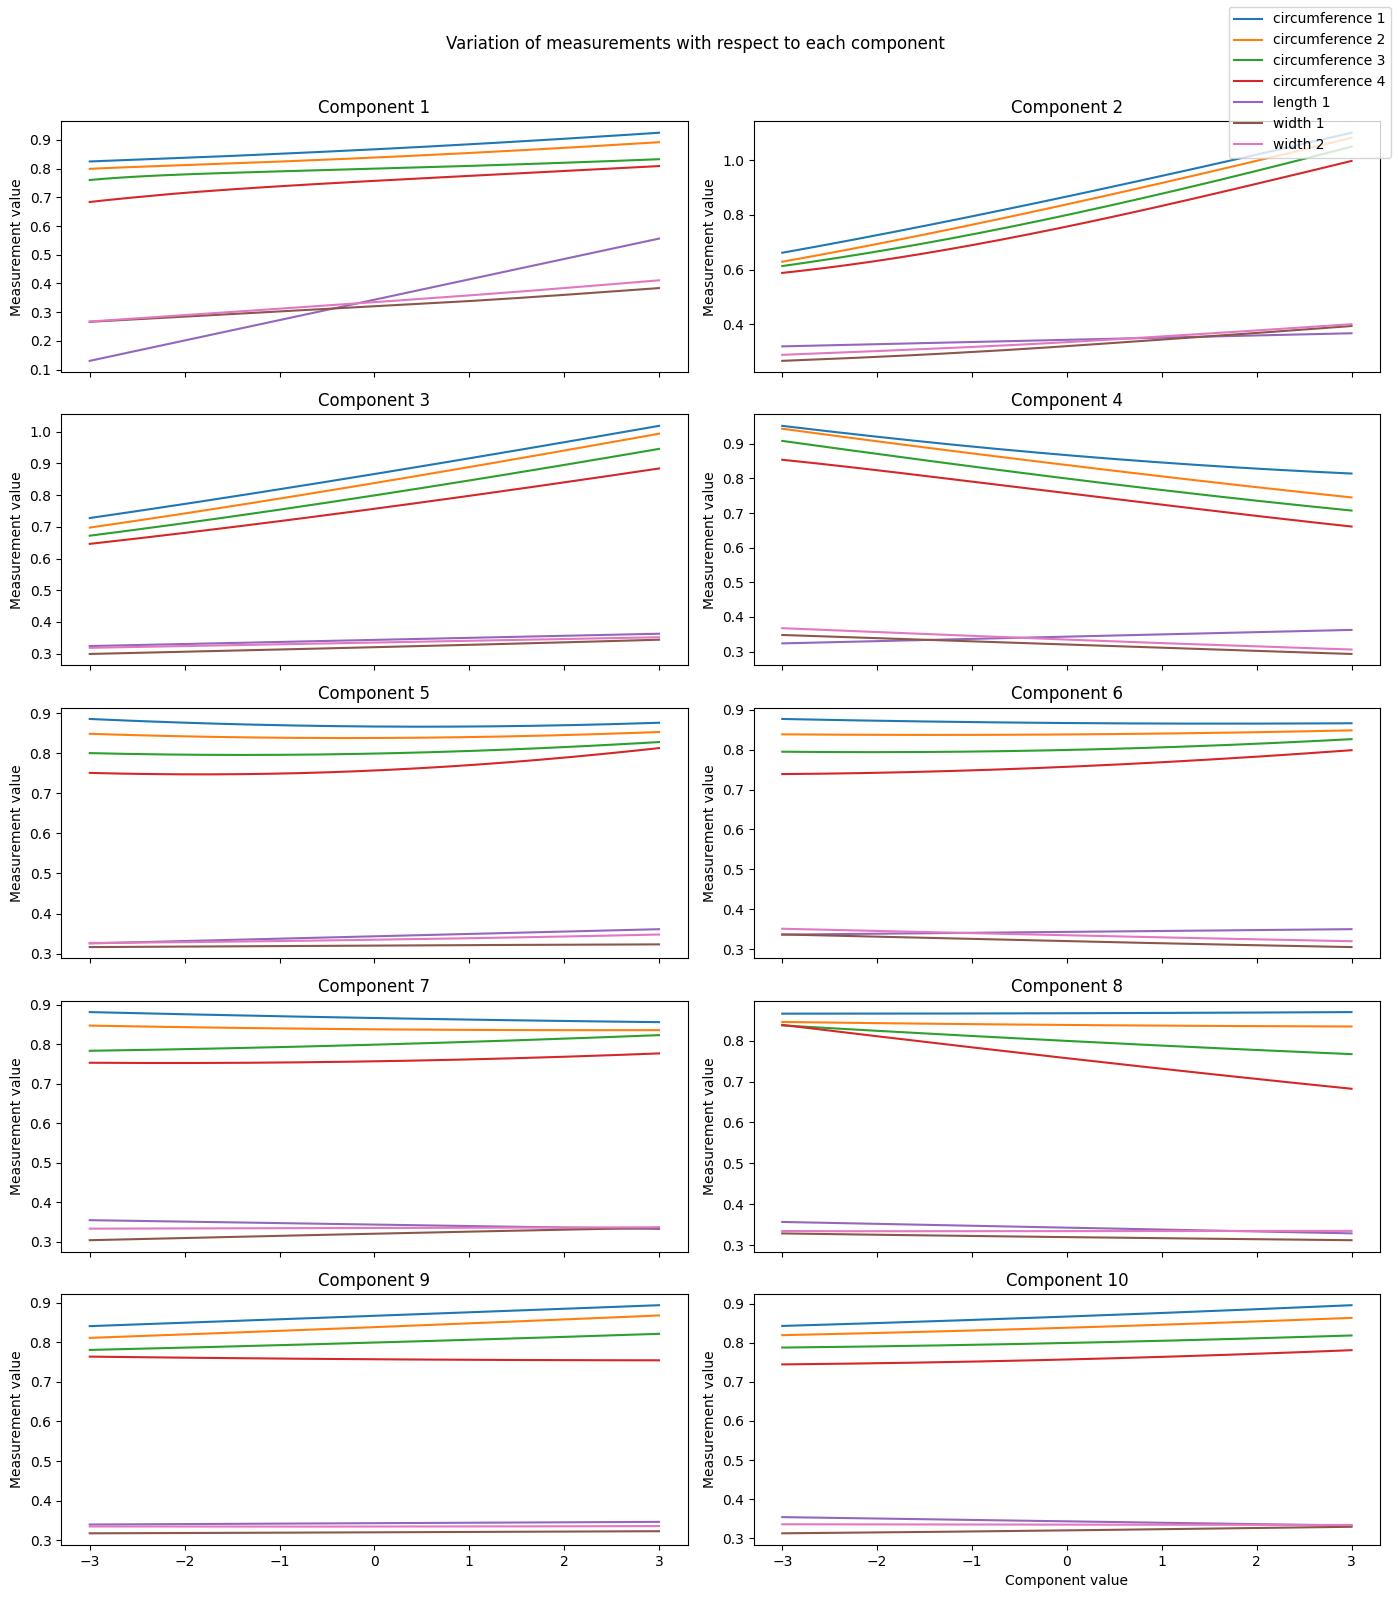

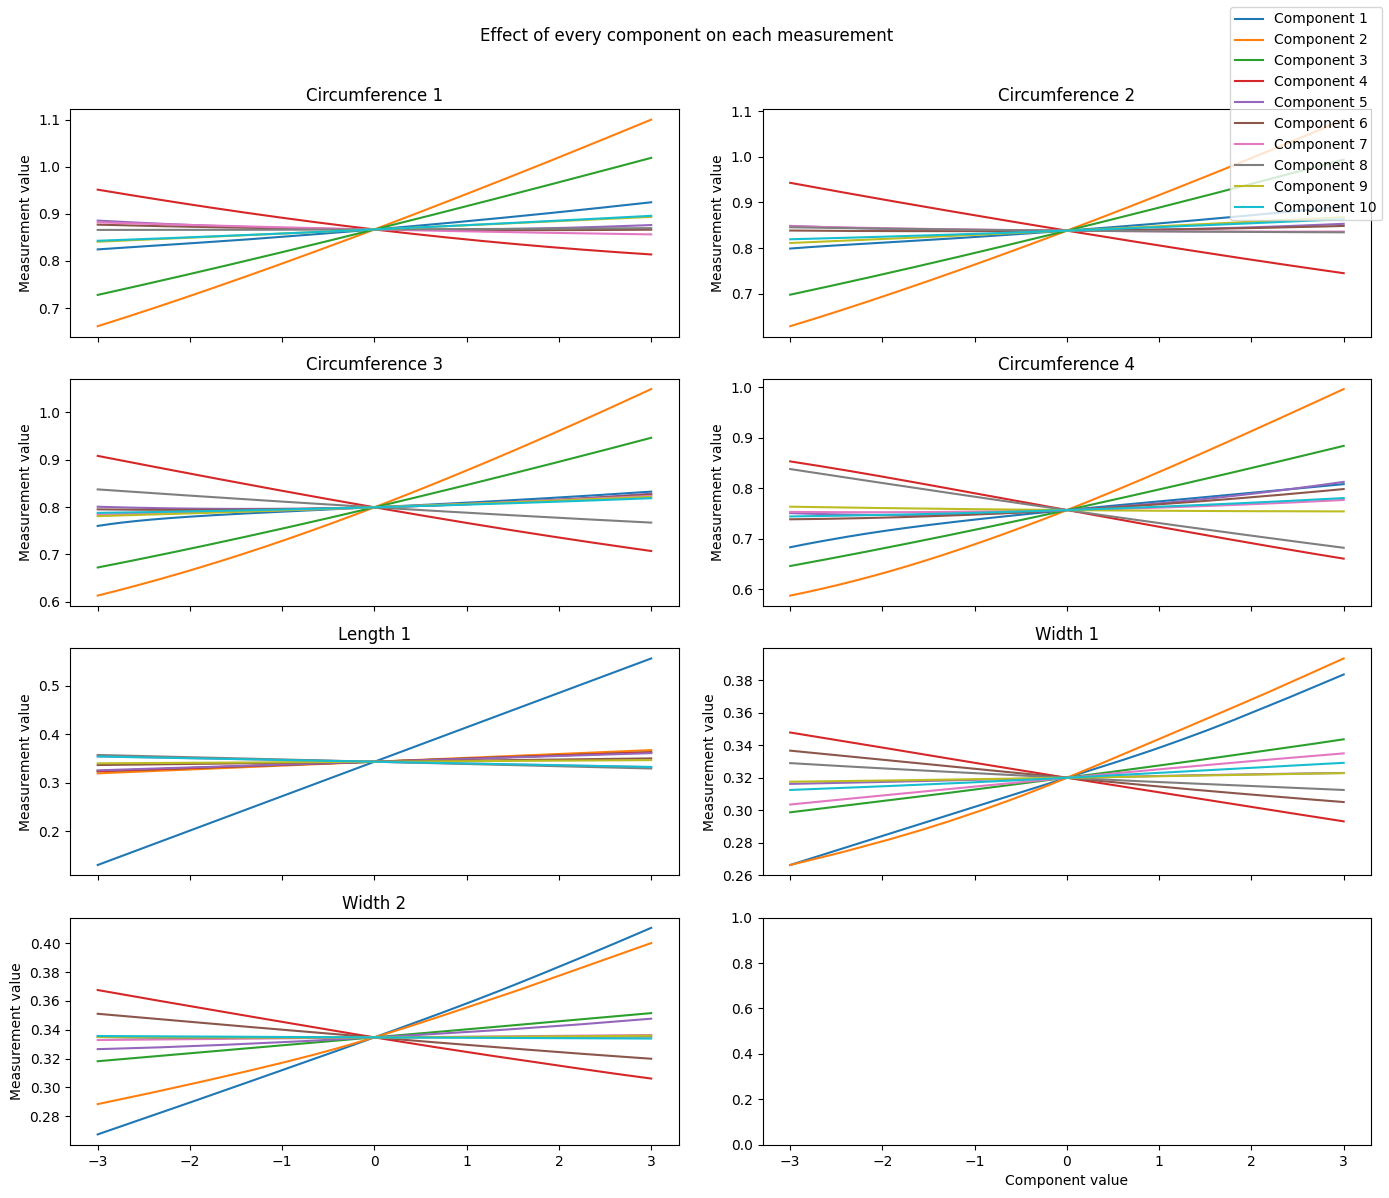

In [ ]:
import matplotlib.pyplot as plt

num_components = component_transforms.shape[1]
num_measurements = len(measurement_details)

# Store all measures for later use
all_measures = []
x_vals = []

for i in range(num_components - 1):
    x = torch.linspace(-3, 3, 512)
    components = torch.zeros((512, num_components), dtype=dtype)
    components[:, i] = x
    components = components * component_transforms[1:] + component_transforms[:1]
    components[:, -1] = torch.ones_like(components[:, -1])
    measures = dataset.get_measures(components)
    all_measures.append(measures)
    x_vals.append(x)

# Figure 1: Each component, all measurements (5 rows x 2 columns)
fig1, axs1 = plt.subplots(5, 2, figsize=(14, 16), sharex=True)
axs1 = axs1.flatten()
for i in range(num_components - 1):
    for j in range(num_measurements):
        measure_type = measurement_details[j]["type"]
        type_count = sum(1 for k in range(j) if measurement_details[k]["type"] == measure_type) + 1
        axs1[i].plot(x_vals[i].numpy(), all_measures[i][:, j].numpy(), label=f"{measure_type} {type_count}")
    axs1[i].set_ylabel("Measurement value")
    axs1[i].set_title(f"Component {i+1}")
axs1[-1].set_xlabel("Component value")
fig1.suptitle("Variation of measurements with respect to each component")
# Only show legend once
handles, labels = axs1[0].get_legend_handles_labels()
fig1.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Figure 2: Each measurement, all components (4 rows x 2 columns)
fig2, axs2 = plt.subplots(4, 2, figsize=(14, 12), sharex=True)
axs2 = axs2.flatten()
for j in range(num_measurements):
    for i in range(num_components - 1):
        axs2[j].plot(x_vals[i].numpy(), all_measures[i][:, j].numpy(), label=f"Component {i+1}")
    axs2[j].set_ylabel("Measurement value")
    axs2[j].set_title(f"{measurement_details[j]['name']}")
axs2[-1].set_xlabel("Component value")
fig2.suptitle("Effect of each component on measurements")
# Only show legend once
handles, labels = axs2[0].get_legend_handles_labels()
fig2.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

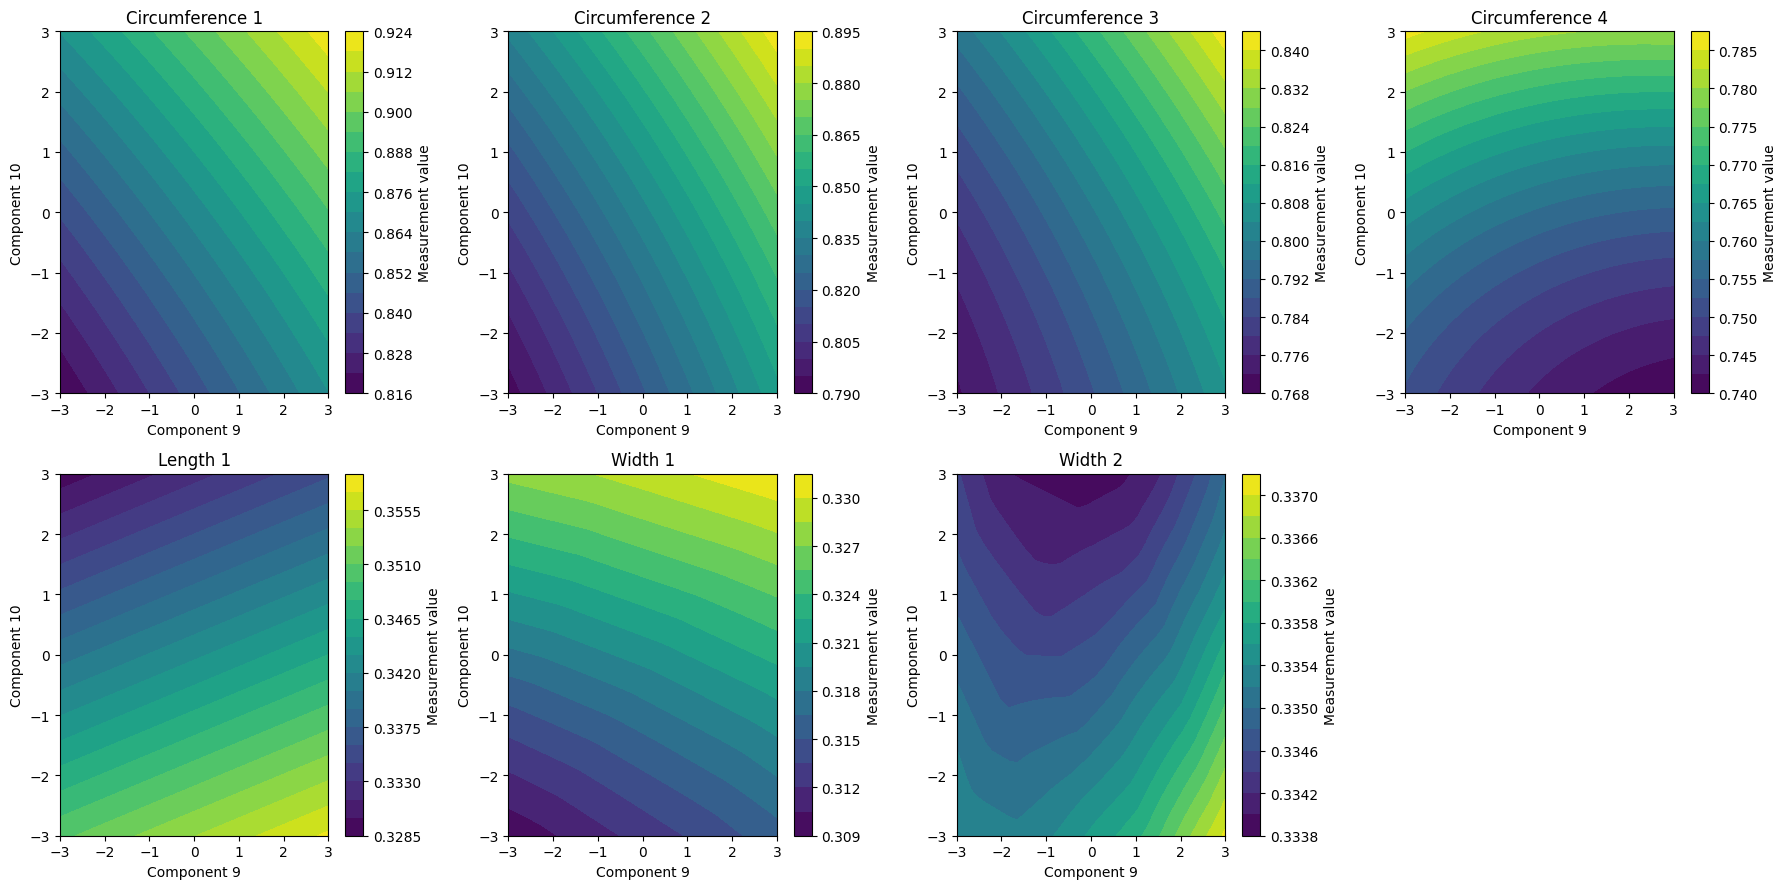

In [ ]:
# Sweep two components at a time
import matplotlib.pyplot as plt

comp_i, comp_j = 8,9  # indices of components to sweep
x = torch.linspace(-3, 3, 32)
y = torch.linspace(-3, 3, 32)
X, Y = torch.meshgrid(x, y)
components = torch.zeros((X.numel(), num_components), dtype=dtype)
components[:, comp_i] = X.flatten()
components[:, comp_j] = Y.flatten()
components = components * component_transforms[1:] + component_transforms[:1]
components[:, -1] = 1.0  # scale

measures = dataset.get_measures(components)
measure_idx = 0  # which measurement to plot

Z = measures[:, measure_idx].reshape(X.shape)
fig, axs = plt.subplots(2, 4, figsize=(18, 9))
axs = axs.flatten()
for idx in range(num_measurements):
    Z = measures[:, idx].reshape(X.shape)
    cf = axs[idx].contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=20)
    axs[idx].set_xlabel(f'Component {comp_i+1}')
    axs[idx].set_ylabel(f'Component {comp_j+1}')
    axs[idx].set_title(f'{measurement_details[idx]["name"]}')
    plt.colorbar(cf, ax=axs[idx], label='Measurement value')
# Hide the unused subplot
if len(axs) > num_measurements:
    axs[-1].axis('off')
plt.tight_layout()
plt.show()